# Torrero Agronomy
### A hypothetical agronomy company creating a worldwide agricultural commodity recommender

Libraries

In [100]:
from botocore.exceptions import ClientError
import boto3
import geopandas
from geopy.geocoders import Nominatim
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyathena import connect
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.serializers import CSVSerializer
import scipy
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### Create and Verify Database

In [101]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [102]:
ingest_create_athena_db_passed = False

In [103]:
# Set db name
database_name = "crops"

In [104]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [105]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [106]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [107]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default


In [108]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [109]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"


In [110]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [111]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


# Exploratory Data Analysis

In [202]:
# Defining consistent graph color for the notebook
pres_green = "#023831"

In [112]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)

In [113]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 113454 rows in the data frame and 11 columns


## Adding in Geographic Data
Since we're using location as a predictor, we'll need to grab the coordinates of each country. There are also regions that we'll need to delete

In [114]:
# Functions to find coordinates
geolocater = Nominatim(user_agent="CloudTeam1", timeout = None)
def geolocate_lat(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.latitude)
    except:
        return np.nan
    
def geolocate_long(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.longitude)
    except:
        return np.nan

In [115]:
# Get the coordinates and build df for them
countries = df['area'].unique()
countries = pd.Series(countries)

latitudes = countries.apply(geolocate_lat)
longitudes = countries.apply(geolocate_long)

coord = pd.DataFrame(list(zip(countries, latitudes, longitudes)),
             columns=['area', 'lat', 'long'])

In [116]:
# Merge our data
df = pd.merge(df, coord, left_on=['area'], right_on=['area'], how="inner")

## NA Analysis

In [117]:
nan_count = df.isna().sum()
print(nan_count)

area                   0
item                   0
year                   0
production          2570
nitrogen            2149
phosphate           4453
potassium           5433
value              40675
avg_rain               0
avg_temp               0
total_value_usd    40918
lat                 4224
long                4928
dtype: int64


The large amount of NAs in total_value_usd appears to be from value. Likely a country not reporting in USD or based on the year. Either one would be fairly hard to get the correct value as we would need to look up the conversion rates for every country at the specific times.

In [118]:
# Lets create a view as an example of how to utilize the Athena DB

client = boto3.client('athena')

s3_path_views = "s3://sagemaker-studio-998234604495-nyhifbo32oo/views/"


years_ViewName = 'TotalValueNAByYear'
TotalValueNAByYear_statment = """ CREATE OR REPLACE VIEW {}.{} AS
SELECT year, SUM(CASE WHEN total_value_usd IS NULL then 1 ELSE 0 END) AS Total_Value_USD_Nulls
FROM {}.{}
GROUP BY year
ORDER BY 2 desc
""".format(database_name, years_ViewName, database_name, table_name_csv) 

# Execute the query to create the view
try:
    response = client.start_query_execution(
        QueryString=TotalValueNAByYear_statment,
        QueryExecutionContext={
            'Database': database_name
        },
        ResultConfiguration={
            'OutputLocation': s3_path_views
        }
    )
    print('View created successfully')
except ClientError as e:
    print('Error creating view: {}'.format(e))

View created successfully


In [119]:
# Load a df from the view
yearsNA_statement = """SELECT * FROM {}.{}""".format(database_name, years_ViewName)
print(yearsNA_statement)
df_yearsNA = pd.read_sql(yearsNA_statement, conn)

SELECT * FROM crops.TotalValueNAByYear


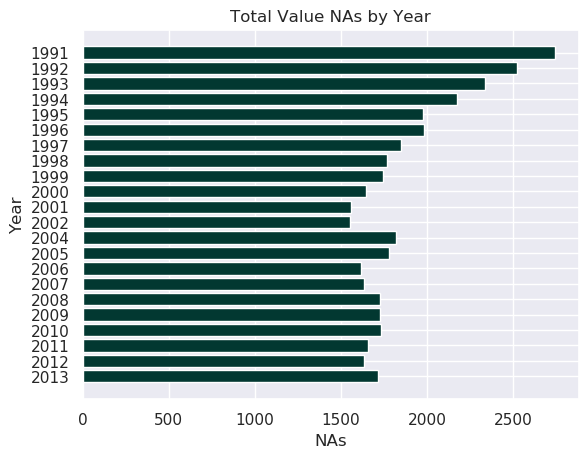

In [203]:
# Plot our view
df_yearsNA = df_yearsNA.sort_values(by=['year'], ascending=False)
bars = df_yearsNA['year']
height = df_yearsNA['Total_Value_USD_Nulls']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height, color = pres_green)

plt.title("Total Value NAs by Year")
plt.ylabel("Year")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

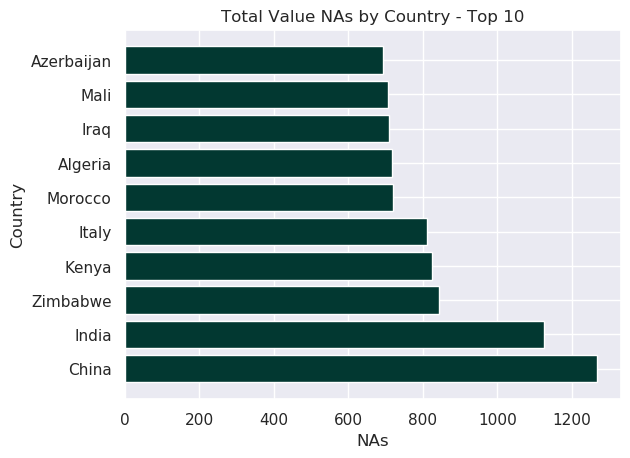

In [204]:
# By Country - Lets create a view as an example of how the Athena DB can be utilized

na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height, color = pres_green)

plt.title("Total Value NAs by Country - Top 10")
plt.ylabel("Country")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [122]:
df_nona = df.dropna()
df_nona_china = df_nona[df_nona['area'] == "China"]
df_china = df[df['area'] == "China"]

print("China loses", df_china.shape[0] - df_nona_china.shape[0], "observations when we take out NAs leaving us with", df_nona_china.shape[0], "observations left for the country")

China loses 1268 observations when we take out NAs leaving us with 1460 observations left for the country


### Final clean before EDA
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those.

In [123]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            173
phosphate          1376
potassium          1615
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
lat                2041
long               2629
dtype: int64


## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

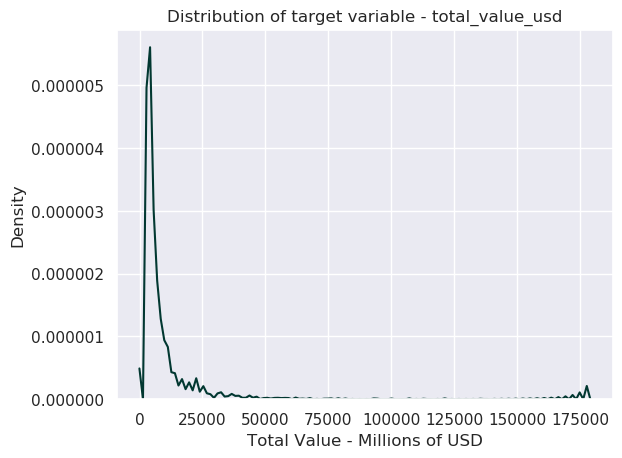

In [205]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False, color = pres_green)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

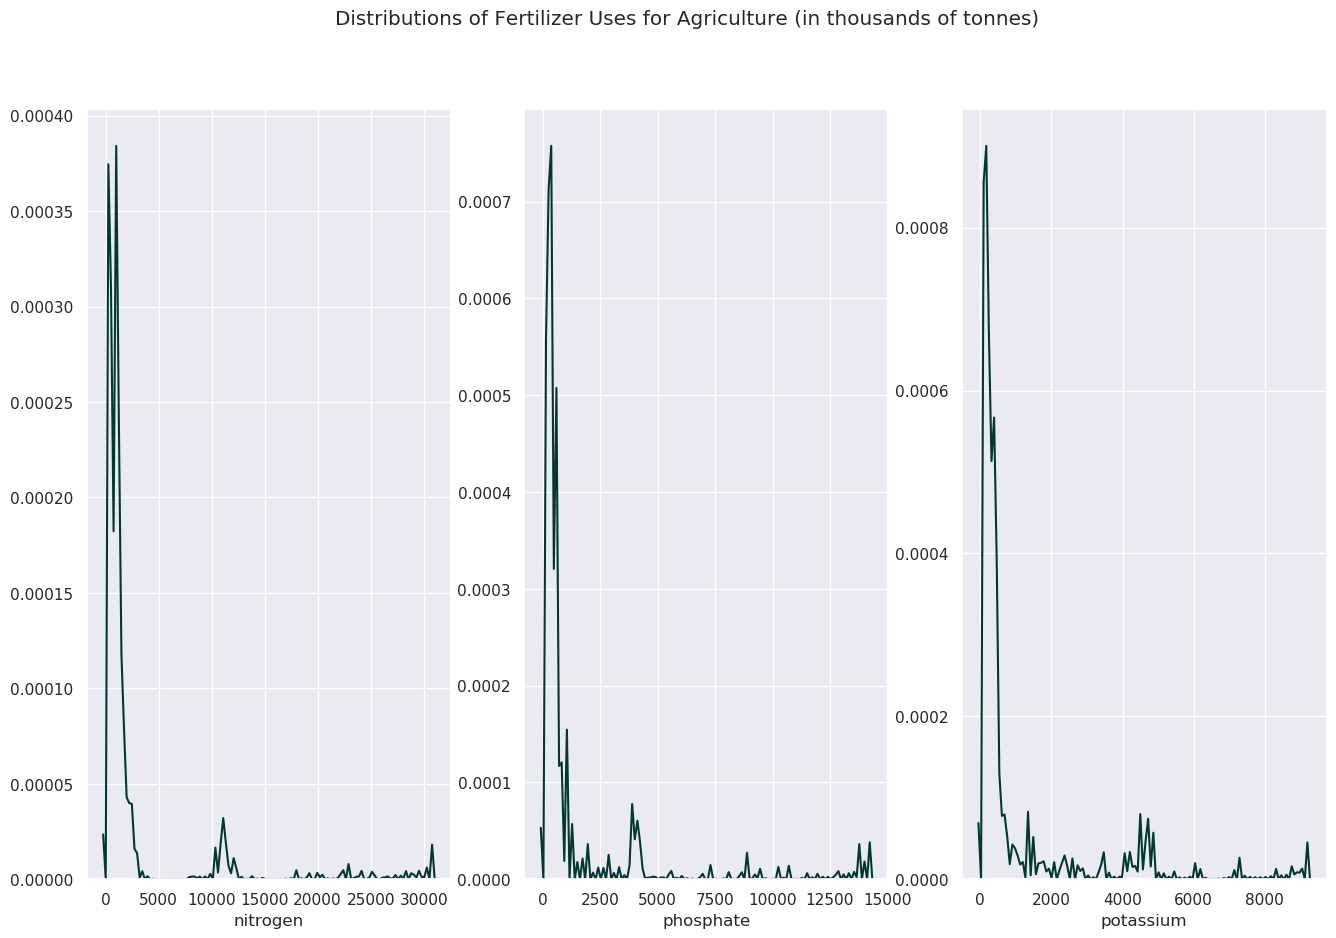

In [206]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False, color = pres_green)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False, color = pres_green)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False, color = pres_green)

plt.show()


Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

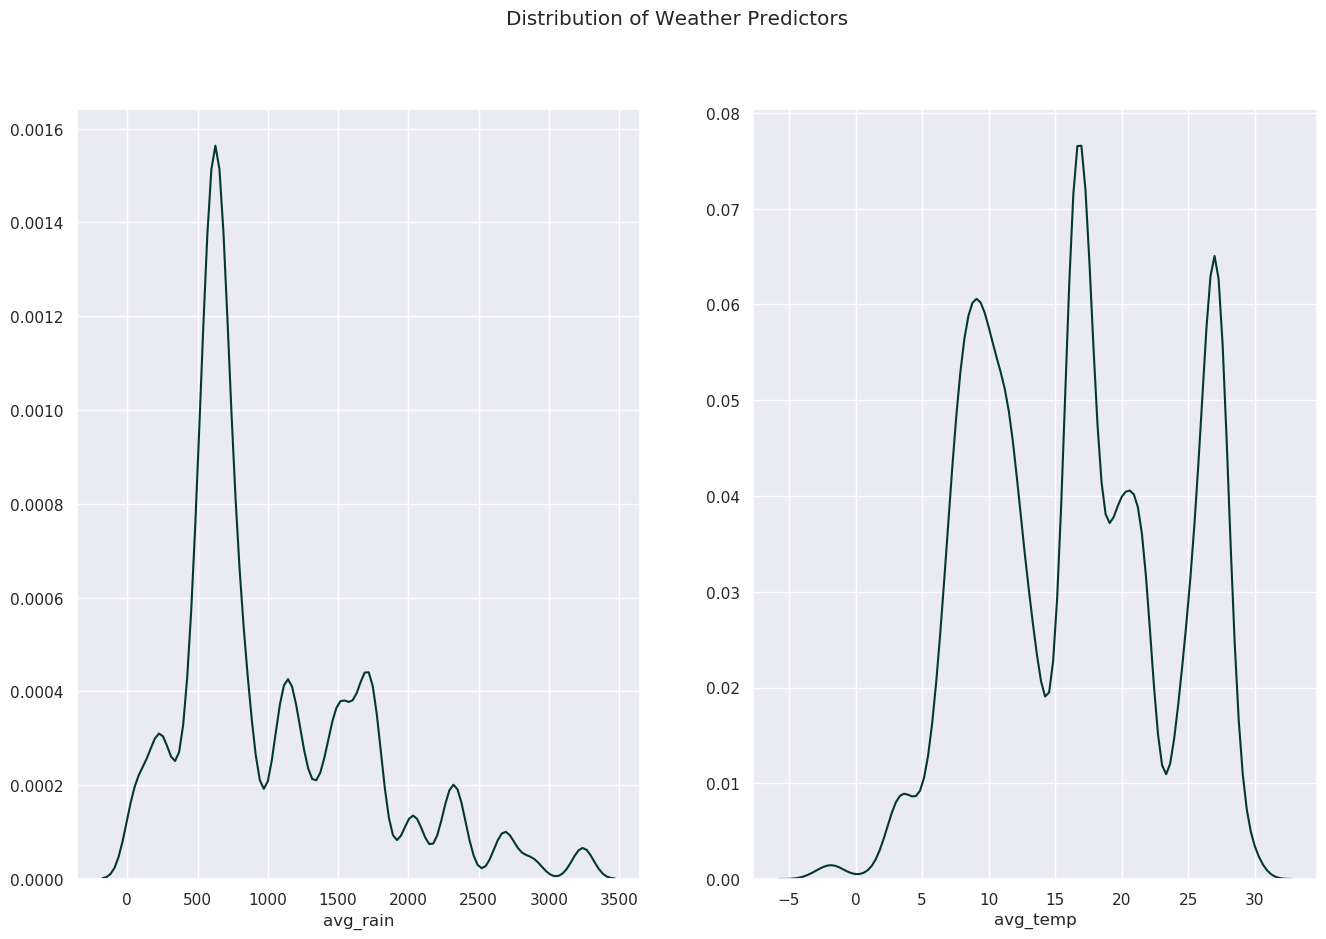

In [207]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False, color = pres_green)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False, color = pres_green)

plt.show()

Correlation Matrix for Numeric Features

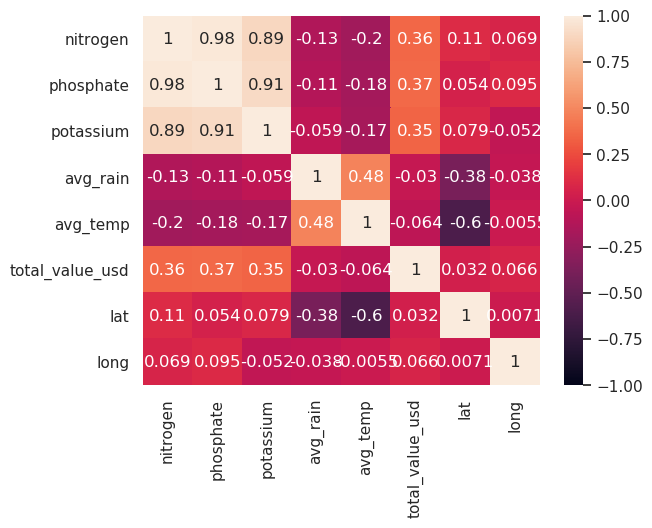

In [127]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [128]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#### Fix Country names:
Some names aren't matching between world and df, need to match them since we're merging on them.

In [129]:
world['name'].unique();

In [130]:
world_country = ['United States of America', 'Dem. Rep. Congo', 'Congo']
df_country = ["United States", "Congo, Dem. Rep.", "Congo, Rep."]

world2 = world

for (old, new) in zip(world_country, df_country):
    world2['name'] = world['name'].replace(old,new)



### Highest Ag Value 1991-2013

In [131]:
val_country = df_clean.groupby(by="area")["total_value_usd"].sum()

countries = df_clean['area'].unique()
countries = pd.Series(countries)

geos = world2[['name', 'geometry']]
geos

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [132]:
gdf_value['value'] = gdf_value[['value']]/1_000_000_000_000

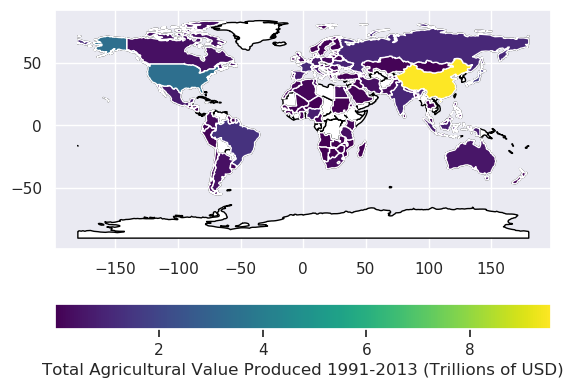

In [133]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_value.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})
plt.show()

### Avg. Temperatures

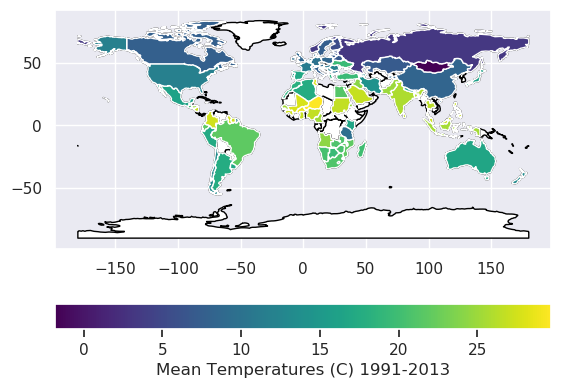

In [134]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_temp"].mean()


val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

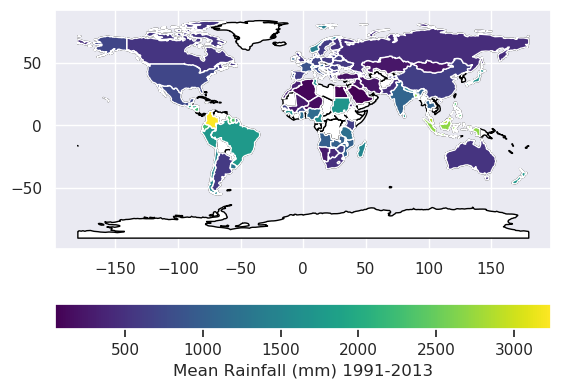

In [135]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_rain"].mean()

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [136]:
val_country = df_clean.groupby(by="area")["nitrogen"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [137]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

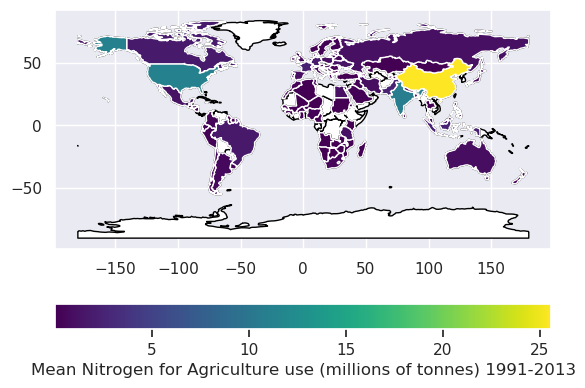

In [138]:
%%capture --no-display
base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})

plt.show()

### Phosphate

In [139]:
val_country = df_clean.groupby(by="area")["phosphate"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_phos = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [140]:
gdf_phos['value'] = gdf_phos[['value']]/1_000_000

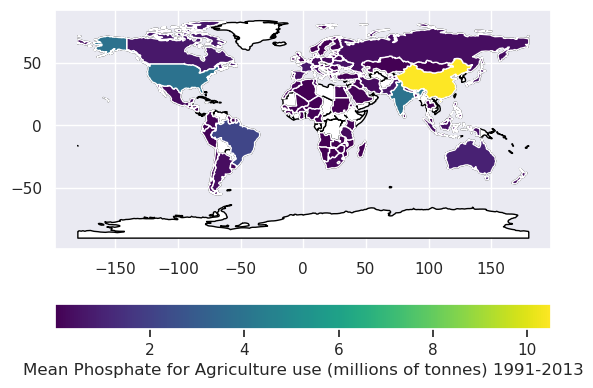

In [141]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_phos.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Phosphate for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Potassium

In [142]:
val_country = df_clean.groupby(by="area")["potassium"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_pot = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [143]:
gdf_pot['value'] = gdf_pot[['value']]/1_000_000

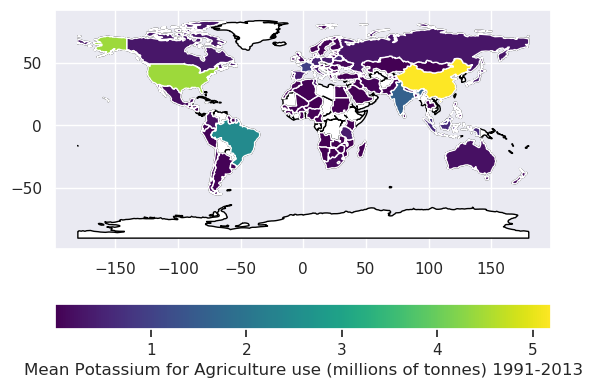

In [144]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_pot.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Potassium for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

## Categorical Anaylsis

#### "Area" and "item" are the only categorical variables

In [210]:
cat_df = pd.DataFrame(df, columns =['area', 'item'])

### "area" EDA:

In [211]:
#Finding the count of countries that are in the Area column:

print ("There are", cat_df['area'].nunique(), "different areas/countries in the dataset")

There are 103 different areas/countries in the dataset


In [212]:
#examining unique values of countries that are in the dataset
cat_df['area'].unique()


array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Eritrea', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guyana', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan',
       'Kenya', 'Latvia', 'Lebanon', 'Lithuania', 'Madagascar', 'Malawi',
       'Malaysia', 'Mali', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco',
       'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qata

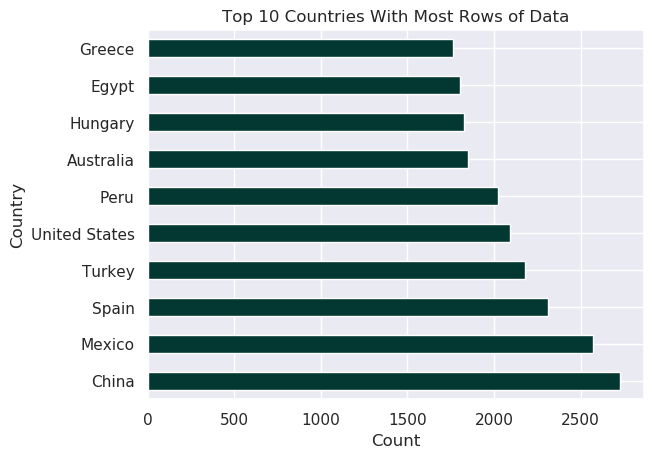

In [213]:
#frequency of each country: 
cat_df['area'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Countries With Most Rows of Data', 
                                            color = pres_green)
plt.ylabel('Country')
plt.xlabel('Count')
plt.show()

#### Countries with most rows of data include China, Mexico, Spain & Turkey

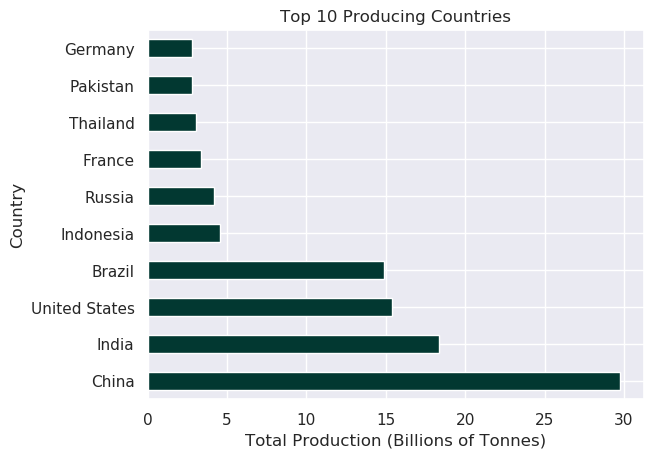

In [214]:
#Total production based on country
p_country = df.production.groupby(df['area']).sum().astype(int).reset_index(name="sum")
p_country = p_country.sort_values(by=['sum'], ascending=False).head(10)


p_country2 = p_country
p_country2['sum'] = p_country2['sum']/1_000_000_000

p_country2.plot(kind='barh', title= 'Top 10 Producing Countries', x=('area'), y = ('sum'), 
                color = pres_green, legend = None)



plt.xlabel('Total Production (Billions of Tonnes)')
plt.ylabel('Country')
plt.show()

#### Countries with most production are China, India, United States and Brazil

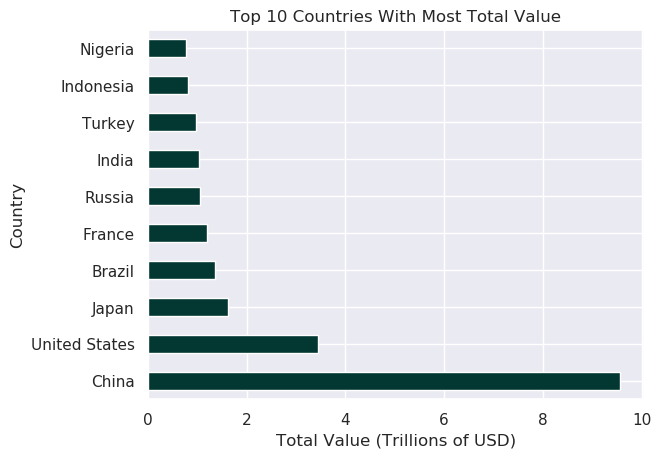

In [215]:
#Total value usd based on country
usd_country = df.total_value_usd.groupby(df['area']).sum().astype(int).reset_index(name="sum")
usd_country = usd_country.sort_values(by=['sum'], ascending=False).head(10)

usd_country2 = usd_country
usd_country2['sum'] = usd_country2['sum']/1_000_000_000_000
usd_country2.plot(kind='barh', title= 'Top 10 Countries With Most Total Value', x=('area'), y = ('sum'), 
                 color = pres_green, legend = None)

plt.ylabel('Country')
plt.xlabel('Total Value (Trillions of USD)')
plt.show()

#### Countries with highest total value USD include China, United States, Japan, and Brazil 

### "Item" EDA

In [151]:
#Finding the count of Items that are in the Item column:

print ("There are", cat_df['item'].nunique(), "different commodities in the dataset")

There are 190 different commodities in the dataset


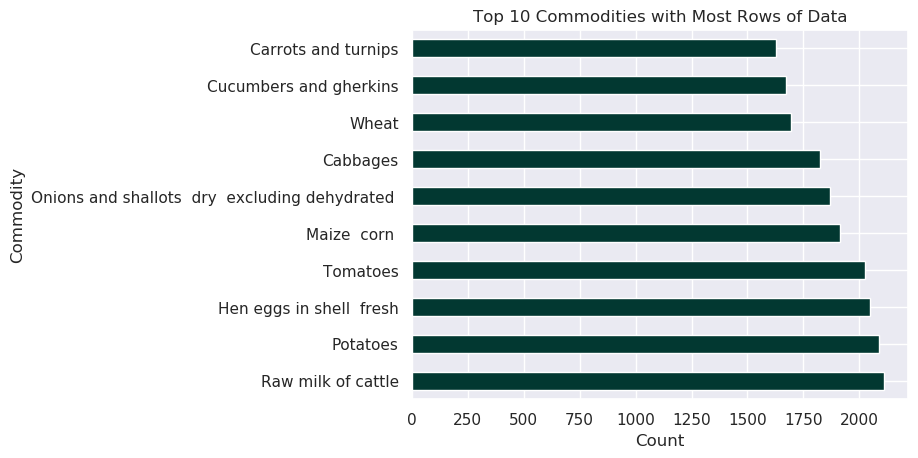

In [216]:
#frequency of each item: 
cat_df['item'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Commodities with Most Rows of Data', 
                                            color = pres_green)

plt.xlabel('Count')
plt.ylabel('Commodity')
plt.show()

#### Top items with most rows of data are hen eggs in shell fresh, raw milk of acttle, potatoes, tomatoes, maize corn, etc. 

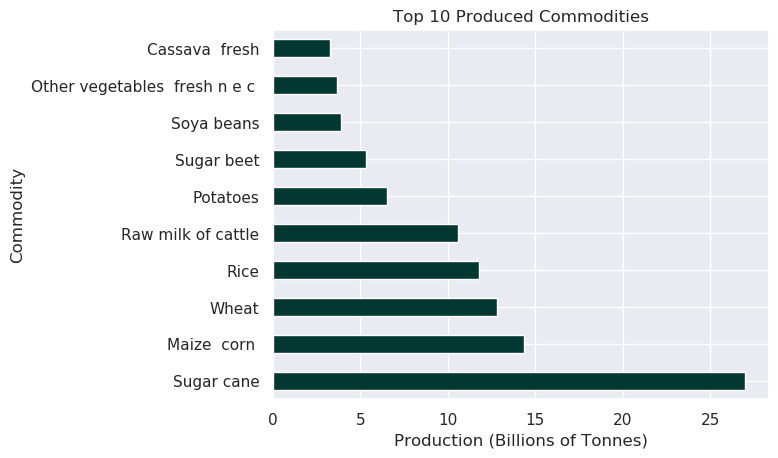

In [217]:
#Total production based on country
I_country = df.production.groupby(df['item']).sum().astype(int).reset_index(name="sum")
I_country = I_country.sort_values(by=['sum'], ascending=False).head(10)

I_country2 = I_country
I_country2['sum'] = I_country2['sum']/1_000_000_000

I_country2.plot(kind='barh', title= 'Top 10 Produced Commodities', x=('item'), y = ('sum'), 
                legend=None, color = pres_green)

plt.xlabel('Production (Billions of Tonnes)')
plt.ylabel('Commodity')
plt.show()

#### Top produced items include sugar cane, maize corn, wheat and rice

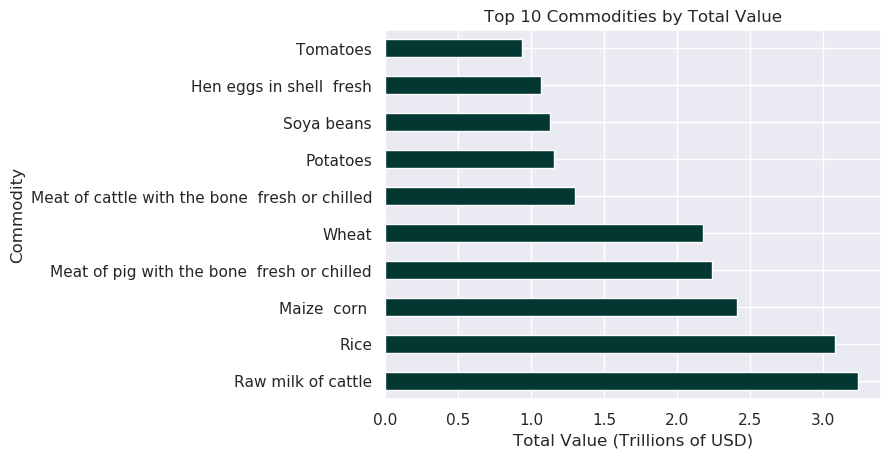

In [218]:
#Total value usd based on Item
usd_item = df.total_value_usd.groupby(df['item']).sum().astype(int).reset_index(name="sum")
usd_item = usd_item.sort_values(by=['sum'], ascending=False).head(10)

usd_item2 = usd_item
usd_item2['sum'] = usd_item2['sum']/1_000_000_000_000


usd_item2.plot(kind='barh', title= 'Top 10 Commodities by Total Value', x=('item'), y = ('sum'), 
               legend = None, color = pres_green)

plt.xlabel('Total Value (Trillions of USD)')
plt.ylabel('Commodity')
plt.show()

#### Items that have highest total value USD include raw milk of cattle, rice, maize corne and meat of pig with the bone fresh or chilled

### Outlier Analysis


In [155]:
summary =pd.DataFrame(df.describe())
summary

,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
count,113454.000000,1.108840e+05,1.113050e+05,1.090010e+05,1.080210e+05,72779.000000,113454.000000,113454.000000,7.253600e+04,109230.000000,108526.000000
mean,2001.954545,1.337219e+06,1.429205e+06,5.956547e+05,3.933367e+05,987.891786,1021.496219,17.001938,4.636290e+08,24.133188,15.591020
std,6.778856,1.099610e+07,4.353015e+06,1.799397e+06,1.124213e+06,1620.114512,681.223616,7.231138,2.745589e+09,25.469789,60.923963
min,1991.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,51.000000,-3.370000,0.000000e+00,-41.500083,-107.991707
25%,1996.000000,5.789000e+03,4.270000e+04,1.800000e+04,9.286000e+03,226.200000,591.000000,10.330000,6.381282e+06,7.877396,-4.837979
50%,2001.500000,4.205850e+04,2.010000e+05,7.500000e+04,4.900000e+04,451.600000,748.000000,16.960000,3.418865e+07,31.172821,19.999962
75%,2008.000000,2.720000e+05,9.146600e+05,3.273870e+05,1.993220e+05,1089.000000,1485.000000,24.100000,1.806696e+08,42.638426,42.352833
max,2013.000000,7.680904e+08,3.080070e+07,1.425946e+07,9.217027e+06,40039.700000,3240.000000,30.420000,1.791078e+11,64.686314,172.834408


In [156]:
num_df = pd.DataFrame(df, columns =['production', 'nitrogen', 'phosphate', 'potassium', 'value', 'avg_rain','avg_temp', 'total_value_usd'])
num_df.head()

,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
1,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
2,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
3,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
4,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN


#### Boxplot for numerical data:

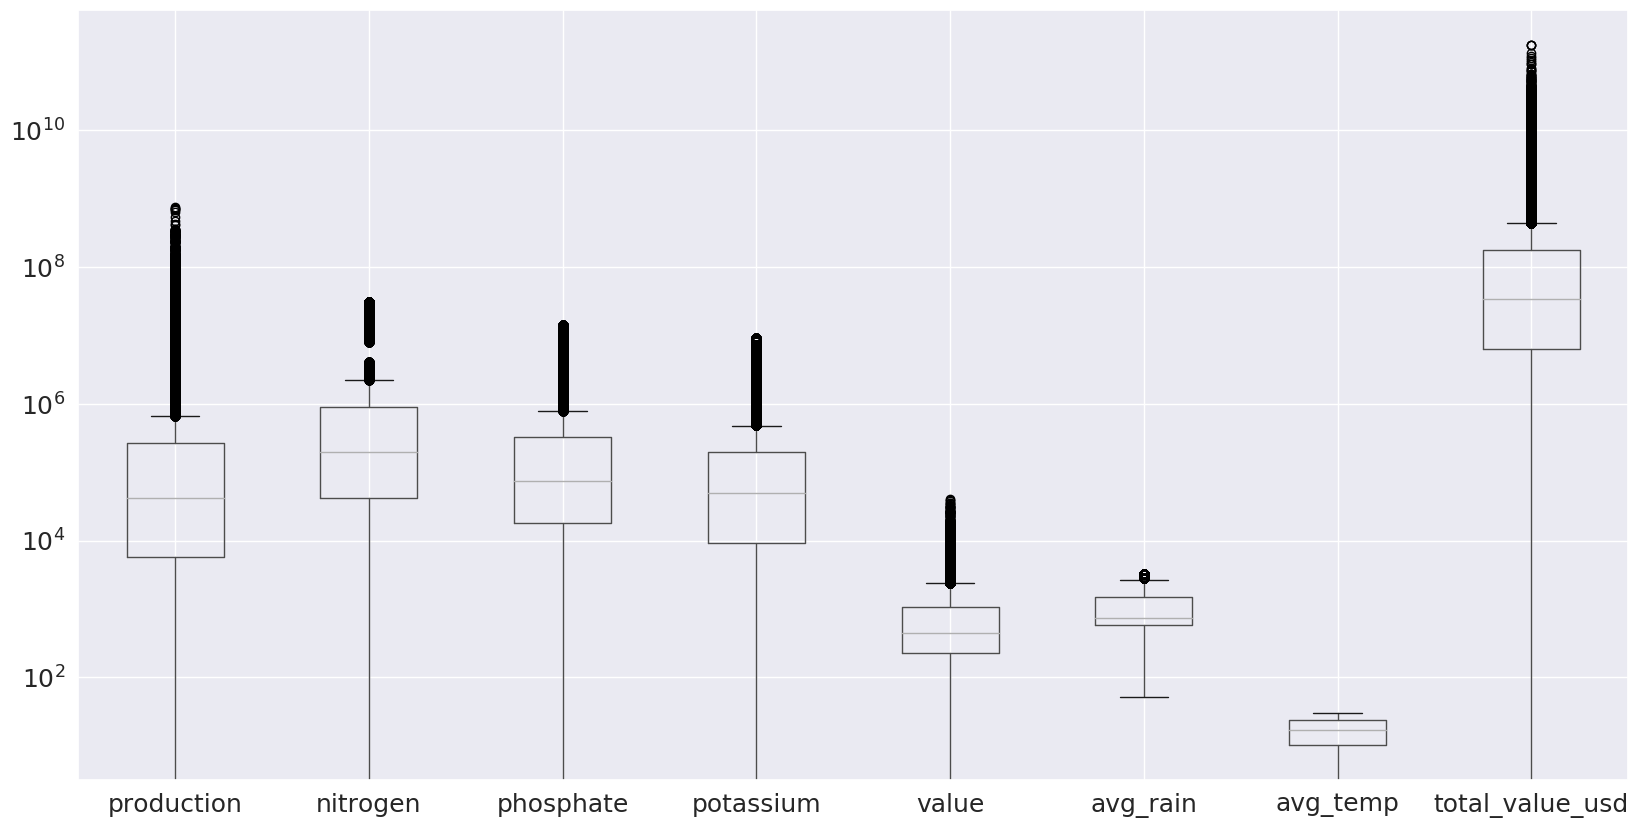

In [157]:
num_df.boxplot(figsize=(20,10), fontsize = 18)
plt.semilogy()
plt.show()

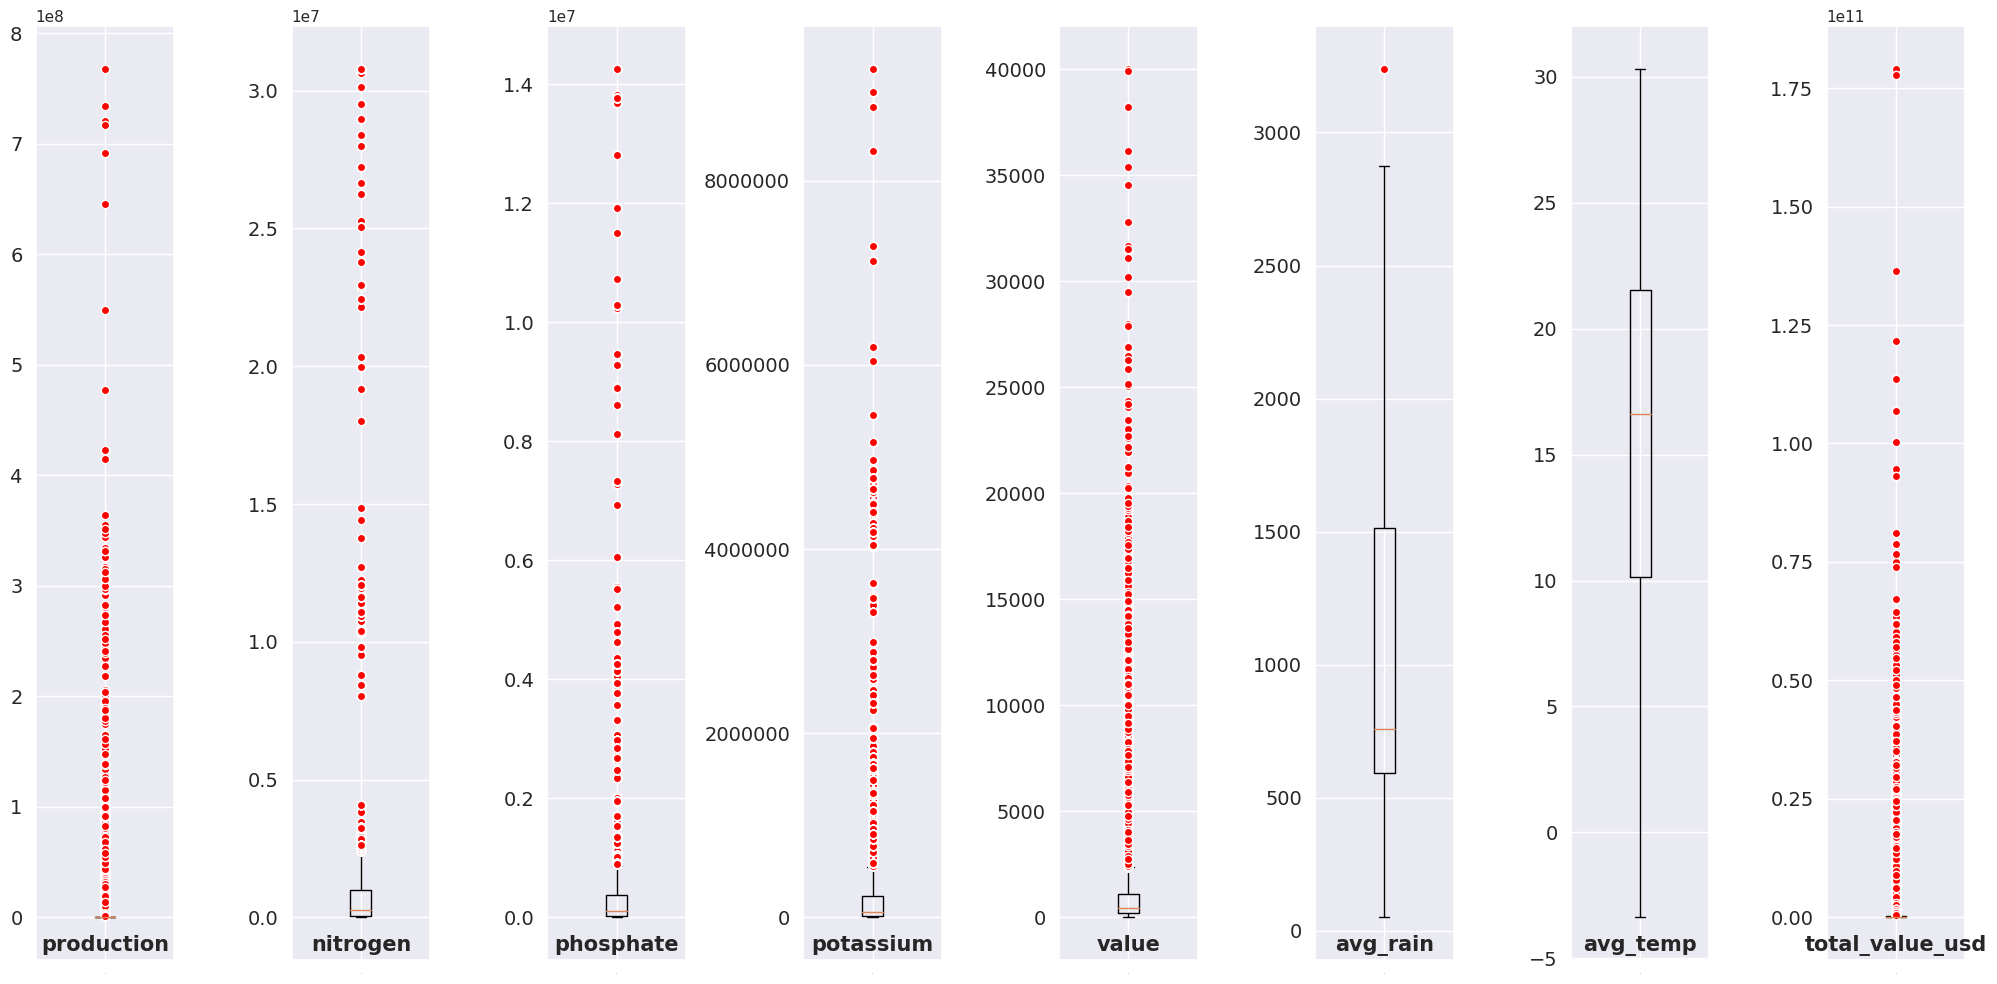

In [158]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

num_df = num_df.dropna()

fig, axs = plt.subplots(1, len(num_df.columns), figsize=(20,10))

for col, ax in enumerate(axs.flat):
    ax.boxplot(num_df.iloc[:,col], flierprops=red_circle)
    ax.set_title(num_df.columns[col], fontsize=15, fontweight='bold', y = 0)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize = 0)
    
plt.tight_layout()
plt.show()

#### It looks like most of the numerical columns have a large amount of outliers. Outliers should be kept considering significant amount of data. Average rain and average temp could possibly be resolved for outliers.

## Data Preparation:
We will not need the production, value, area, or year columns for modeling. Production and value were only used to create total_value_usd, area will be represented numerically through lat and long, and we are not doing any time series forecasting.

In [159]:
df_model = df_clean.drop(['production', 'value', 'area'], axis=1)

### Creating ratio features for the fertilizer columns:

In [160]:
#specifying the fertilizer columns to sum
cols = ['nitrogen', 'phosphate', 'potassium']

#setting up columm for sum:
df_model['fertilizer_sum'] = df_model[cols].sum(axis=1)

#creating ratio columns:

df_model["nitrogen_ratio"] = df_model["nitrogen"]/df_model["fertilizer_sum"]
df_model["phosphate_ratio"] = df_model["phosphate"]/df_model["fertilizer_sum"]
df_model["potassium_ratio"] = df_model["potassium"]/df_model["fertilizer_sum"]

# Drop the old fertilizer variables
df_model = df_model.drop(['nitrogen','phosphate','potassium','fertilizer_sum'], axis=1)

### One hot encode categorical data

In [161]:
cat = df_model[['item']]

ohe = OneHotEncoder(sparse = False).fit(cat)
cat_data = ohe.transform(cat)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names(['item'])).reset_index(drop = True)

# Join to rest of data
df_model_num = df_model.drop(columns=['item'], axis = 1).reset_index(drop=True)
df_model2 = pd.concat([df_model_num, cat_df], axis = 1)

### Splitting Data

We will based on the year, since we'll need to include every commodity for each country and year to generate accurate rating metrics

In [162]:
# Split based on years
train = df_model2[df_model2['year'] <=2011]
val = df_model2[df_model2['year'] == 2012]
test = df_model2[df_model2['year'] == 2013]

# Split training from test and val
X_train = train.drop(['total_value_usd'], axis =1)
y_train = train['total_value_usd']

X_val = val.drop(['total_value_usd'], axis =1)
y_val = val['total_value_usd']

X_test = test.drop(['total_value_usd'], axis =1)
y_test = test['total_value_usd']



# Ensure we split correctly
total = df_model2.shape[0]

print("Train df size: ", X_train.shape[0], " (", round(X_train.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Test df size: ", X_test.shape[0], " (", round(X_test.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Val df size: ", X_val.shape[0], " (", round(X_val.shape[0]/total*100, 2), " percent of the total.)", sep='')

Train df size: 65572 (90.4 percent of the total.)
Test df size: 3444 (4.75 percent of the total.)
Val df size: 3520 (4.85 percent of the total.)


In [163]:
# Removing year that I needed to keep for future 
test_year = X_test['year']
X_test = X_test.drop(columns = ['year'], axis =1)
X_train = X_train.drop(columns = ['year'], axis =1)
X_val = X_val.drop(columns = ['year'], axis = 1)

### Set up scaler and imputer for future modeling pipeline

In [164]:
scaler = StandardScaler(with_mean = False)
imputer = SimpleImputer()

# Modeling

### Create Sparse Matrix
We were having memory issues with dense df's, we'll train with sparse matrices to prevent crashing

In [165]:
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

### Baseline Linear Regression

In [166]:
# Create modeling pipeline
clf = Pipeline(steps = [('scaler', scaler), ('imputer', imputer), 
                        ('linreg', LinearRegression())])



linreg = clf.fit(X_train_sparse, y_train)

# Predict
y_pred = linreg.predict(X_test)

In [167]:
%%capture --no-display
# Create ranking deployment

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = y_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['base_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
baseline_rankings = results2.sort_values(by=['lat','long','year','base_rank'])
baseline_rankings = baseline_rankings[["lat","long", "year", "item", "base_rank"]]

### ElasticNet Regression

In [168]:
%%capture --no-display
# Create pipeline
enet = ElasticNet()
enet_pipe = Pipeline(steps = [('scaler', scaler), ('imputer', imputer), 
                        ('enet', enet)])

# Hyperparameter tuning
alpha = np.arange(0, 1, 0.1)
l1_ratio = [1e-3, 1e-2, 1e-1, 0, 1, 10, 100]
params = dict(enet__alpha=alpha,
              enet__l1_ratio=l1_ratio)

enet_tuned = RandomizedSearchCV(enet_pipe,params, n_jobs = -1, random_state = 1)
enet_tuned.fit(X_train_sparse, y_train)
enet_tuned.best_params_

{'enet__l1_ratio': 0, 'enet__alpha': 0.9}

In [169]:
# Save the final model for faster use in future
enet_final = ElasticNet(l1_ratio = 0, alpha = 0.9)
enet_reg = enet_pipe.fit(X_train_sparse, y_train)
enet_pred = enet_reg.predict(X_test)

In [170]:
%%capture --no-display
# Convert to ranking for eval

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = enet_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['enet_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
enet_rankings = results2.sort_values(by=['lat','long','year','enet_rank'])
enet_rankings = enet_rankings[["lat","long", "year", "item", "enet_rank"]]

# Sagemaker Modeling
### Reprepare Data
The linear learner can't have missing values, lets run our imputer and scaler before we train the models.

In [171]:
# Lets grab the years from the data frame - we won't want to standardize them but need for splitting
year = df_model2[['year']]
df_model3 = df_model2.drop(['year'], axis = 1)

# Move the target to the front
total_value_usd = df_model3['total_value_usd']
df_model3 = df_model3.drop(['total_value_usd'], axis =1)
df_model3.insert(0, 'total_value_usd', total_value_usd)

# Impute the data
AWS_array = imputer.fit_transform(df_model3)

# Convert back into df
df_model_AWS = pd.DataFrame(AWS_array, columns = df_model3.columns)

In [172]:
df_model_AWS2 = pd.concat([year, df_model_AWS], axis = 1)

# Split based on years
train = df_model_AWS2[df_model_AWS2['year'] <=2011]
val = df_model_AWS2[df_model_AWS2['year'] == 2012]
test = df_model_AWS2[df_model_AWS2['year'] == 2013]

# Split training from test and val
X_train = train.drop(['total_value_usd'], axis =1)
y_train = train['total_value_usd']

X_val = val.drop(['total_value_usd'], axis =1)
y_val = val['total_value_usd']

X_test = test.drop(['total_value_usd'], axis =1)
y_test = test['total_value_usd']



# Ensure we split correctly
total = df_model_AWS2.shape[0]

print("Train df size: ", X_train.shape[0], " (", round(X_train.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Test df size: ", X_test.shape[0], " (", round(X_test.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Val df size: ", X_val.shape[0], " (", round(X_val.shape[0]/total*100, 2), " percent of the total.)", sep='')

Train df size: 65572 (90.4 percent of the total.)
Test df size: 3444 (4.75 percent of the total.)
Val df size: 3520 (4.85 percent of the total.)


In [173]:
# Removing year that I needed to keep for future 
test_year = X_test['year']
X_test = X_test.drop(columns = ['year'], axis =1)
X_train = X_train.drop(columns = ['year'], axis =1)
X_val = X_val.drop(columns = ['year'], axis = 1)

In [174]:
X_train_sage = pd.concat([y_train,X_train], axis =1)

In [175]:
s3_client = boto3.client("s3")
BUCKET = "sagemaker-studio-998234604495-nyhifbo32oo"
KEY = "model/Train.csv"
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    X_train_sage.to_csv(csv_buffer, index=False, header=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

In [176]:
# set up our parameters
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=\
        's3://{}/model/Train'.format(BUCKET), content_type='text/csv')

## XGBoost
Set up the container

In [177]:
# Define IAM role
role = get_execution_role()

# set the region of the instance
my_region = boto3.session.Session().region_name 

# this line automatically looks for the XGBoost image URI and 
# builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", 
                                                  my_region, 
                                                  "latest")

print("Success - the MySageMakerInstance is in the " + my_region + \
      " region. You will use the " + xgboost_container + \
      " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


Define the hyper parameters

In [178]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.large',
                                    output_path='s3://{}/output'.format(BUCKET),
                                    sagemaker_session=sess)
# parse in the hyperparameters
xgb.set_hyperparameters(max_depth=5,min_child_weight=2, lambda_bias = 0.5,
                        subsample=0.9,silent=0,
                        objective='reg:linear',num_round=100)

Train

In [ ]:
xgb.fit({'train': s3_input_train})

Deploy and get the predictions

In [180]:
xgb_pred_deploy = xgb.deploy(initial_instance_count = 1,
                             instance_type='ml.m5.large')

-----!

In [181]:


X_test_array = X_test.values

xgb_pred_deploy.serializer = CSVSerializer()

predictions = xgb_pred_deploy.predict(X_test_array).decode('utf-8')

xgb_pred = np.fromstring(predictions[1:], sep=',')
xgb_pred.size

3444

In [182]:
%%capture --no-display
# Convert to ranking for eval

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = xgb_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['xgb_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
xgb_rankings = results2.sort_values(by=['lat','long','year','xgb_rank'])
xbg_rankings = xgb_rankings[["lat","long", "year", "item", "xgb_rank"]]

### Linear Learner
Set up container

In [183]:
%%capture --no-display
linlearn_container = sagemaker.image_uris.retrieve("linear-learner", 
                                                   my_region,
                                                   "latest")

print("Success - the MySageMakerInstance is in the " + my_region + \
      " region. You will use the " + linlearn_container + \
      " container for your SageMaker endpoint.")

### Set up hyperparameters

In [184]:
sess = sagemaker.Session()
linlearn = sagemaker.estimator.Estimator(linlearn_container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.c4.xlarge',
                                    output_path='s3://{}/output'.format(BUCKET),
                                    sagemaker_session=sess)

                
#Setting up hyperparameters - We'll just use the default for now
linlearn.set_hyperparameters(
    predictor_type="regressor")

### Train

In [ ]:
linlearn.fit({'train': s3_input_train})

### Deploy

In [186]:
%%capture --no-display

linlearn_pred_deploy = linlearn.deploy(initial_instance_count = 1,
                             instance_type='ml.m5.large')

### Get Predictions

In [187]:
%%capture --no-display

linlearn_pred_deploy.serializer = csv_serializer
linlearn_pred_deploy.deserializer = json_deserializer

X_test_array = X_test.values


result = linlearn_pred_deploy.predict(X_test_array)
linlearn_pred = np.array([res['score'] for res in result['predictions']])

In [188]:
%%capture --no-display
# Convert to ranking for eval

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = linlearn_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['linlearn_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
linlearn_rankings = results2.sort_values(by=['lat','long','year','linlearn_rank'])
linlearn_rankings = linlearn_rankings[["lat","long", "year", "item", "linlearn_rank"]]

# Model Evaluation

Get the actual rankings from the test dataset

In [189]:
%%capture --no-display
# Create test df ranks for calculating metrics

# First fix years issue
test_rank = X_test.copy()
test_rank['year'] = test_year

# Join the predicitons
test_rank['pred'] = y_test

# Reverse the one hot encoding
reverse_onehot = test_rank.iloc[: ,7:195].idxmax(1)
test_rank2 = test_rank.iloc[:, np.r_[0:7,195:197]]
test_rank2['item'] = pd.Series(reverse_onehot)
test_rank2['item'] = test_rank2['item'].str.replace("item_", "")

test_rank2['group_rank'] = test_rank2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
test_rank_final = test_rank2.sort_values(by=['lat','long','year','group_rank'])

test_rank_final = test_rank_final[["lat","long", "year", "item", "group_rank"]]

## Root Mean Square Error of ranking

In [190]:
# Baseline
base_merge = pd.merge(test_rank_final, baseline_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
base_mse = mean_squared_error(base_merge['group_rank'], base_merge['base_rank'])
base_rmse = math.sqrt(base_mse)

# Enet
enet_merge = pd.merge(test_rank_final, enet_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
enet_mse = mean_squared_error(enet_merge['group_rank'], enet_merge['enet_rank'])
enet_rmse = math.sqrt(enet_mse)

# XGBoost
xgb_merge = pd.merge(test_rank_final, xgb_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
xgb_mse = mean_squared_error(xgb_merge['group_rank'], xgb_merge['xgb_rank'])
xgb_rmse = math.sqrt(xgb_mse)

# Linear Learner
ll_merge = pd.merge(test_rank_final, linlearn_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
ll_mse = mean_squared_error(ll_merge['group_rank'], ll_merge['linlearn_rank'])
ll_rmse = math.sqrt(ll_mse)

## Spearman Correlation Coefficient

In [191]:
base_rho, base_p = spearmanr(base_merge['group_rank'], base_merge['base_rank'])
enet_rho, enet_p = spearmanr(enet_merge['group_rank'], enet_merge['enet_rank'])
xgb_rho, xgb_p = spearmanr(xgb_merge['group_rank'], xgb_merge['xgb_rank'])
ll_rho, ll_p = spearmanr(ll_merge['group_rank'], ll_merge['linlearn_rank'])

Combine everyting into a df to plot

In [192]:
Models = ['Lin. Reg.', 'ENet', 'XGBoost', 'Linear Learner']
RMSE = [base_rmse, enet_rmse, xgb_rmse, ll_rmse]
rho = [base_rho, enet_rho, xgb_rho, ll_rho]
p = [base_p, enet_p, xgb_p, ll_p]

Results = pd.DataFrame(list(zip(Models, RMSE, rho, p)),
                       columns = ['Model', 'RMSE', 'Spearman_r', 'Spearman_p'])
Results

,Model,RMSE,Spearman_r,Spearman_p
0,Lin. Reg.,16.758564,0.569437,4.313986e-278
1,ENet,16.291208,0.585046,4.049751e-297
2,XGBoost,14.534771,0.634693,0.000000e+00
3,Linear Learner,17.281438,0.538932,8.832708e-259


### RMSE Plot

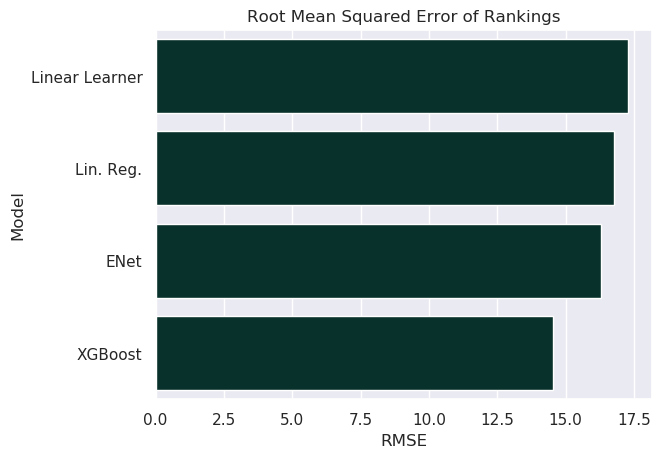

In [219]:
Res_rmse = Results.sort_values(by=['RMSE'], ascending=False)

sns.barplot(y = 'Model', x = 'RMSE', data = Res_rmse, color = pres_green)
plt.title("Root Mean Squared Error of Rankings")
plt.show()

### Spearman Plot

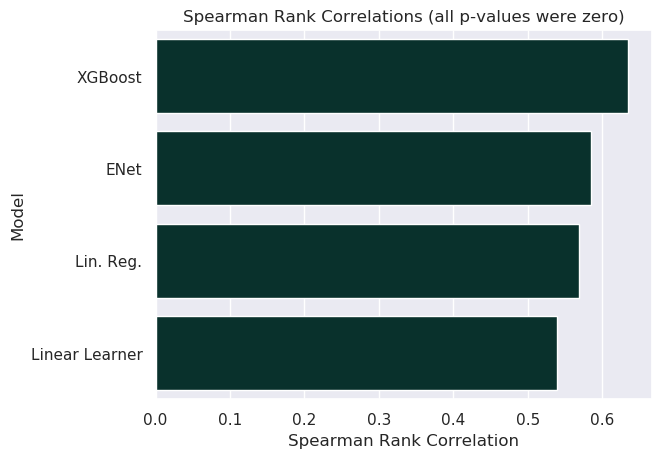

In [220]:
Res_spear = Results.sort_values(by=['Spearman_r'], ascending=False)

sns.barplot(y = 'Model', x = 'Spearman_r', data = Res_spear, color = pres_green)
plt.xlabel('Spearman Rank Correlation')
plt.title("Spearman Rank Correlations (all p-values were zero)")
plt.show()

### Scatterplot of results with best model (XGBoost)

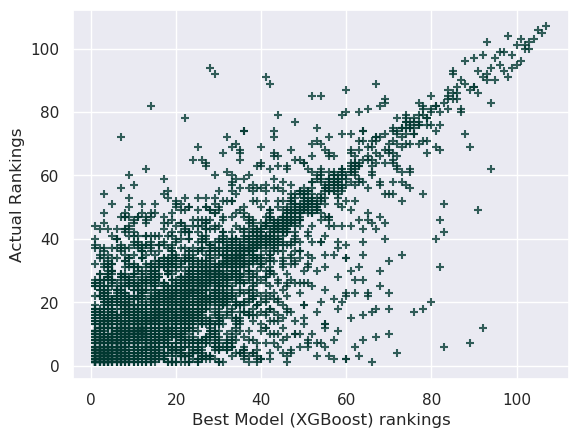

In [221]:
sns.regplot(x = xgb_merge['xgb_rank'], y = xgb_merge['group_rank'], fit_reg = False, marker = "+", color = pres_green)
plt.xlabel("Best Model (XGBoost) rankings")
plt.ylabel("Actual Rankings")
plt.show()

In [201]:
# Finally lets save our predictions to a S3 bucket

s3_client = boto3.client("s3")
BUCKET = "sagemaker-studio-998234604495-nyhifbo32oo"
KEY = "model/XGRankings.csv"
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    xgb_merge.to_csv(csv_buffer, index=False, header=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

# Shutting Down Kernel To Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript
​
try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}